# An investigation on the Centroid and Loads axis location in Fiber Sections

In this Jupyter the Centroid of a rectangle fiber section is investigated and by changing the location of the Section loads axis (using '-noCentroid') and its effect on the results are watched. Results are checked by handy calculations.

By: [Bijan Sayyafzadeh](linkedin.com/in/bijan-sayyafzadeh-6027aa7a) [Email](B.sayyaf@yahoo.com) [Github](https://github.com/BijanSeif)

## Cantiliver Elastic Model Function

In [1]:
def Model(P, Mz, crdsIz, crdsIy, crdsJz, crdsJy, numSubdivY, numSubdivZ):
    import openseespy.opensees as ops

    ops.wipe()
    ops.model('basic','-ndm',3)
    L=100
    ops.node(1,0,0,0)
    ops.node(2,L,0,0)
    ops.fix(1,1,1,1,1,1,1)

    matTag=1
    E=2.1e6
    epsyP=1
    ops.uniaxialMaterial('ElasticPP', matTag, E, epsyP)

    transfTag=1
    ops.geomTransf('Linear', transfTag,*[0,0,1])

    secTag=1
    GJ=1
    ops.section('Fiber', secTag, '-GJ', GJ,'-noCentroid')


    crdsI=[crdsIy, crdsIz]
    crdsJ=[crdsJy, crdsJz]
    b=abs(crdsIz-crdsJz)
    h=abs(crdsIy-crdsJy)
    I=b*h**3/12
    ops.patch('rect', matTag, numSubdivY, numSubdivZ, *crdsI, *crdsJ)


    integrationTag=1
    N=3
    ops.beamIntegration('Radau', integrationTag, secTag, N)


    eleTag=1
    eleNodes=[1,2]
    ops.element('forceBeamColumn', eleTag, *eleNodes, transfTag, integrationTag)

    tstag=1
    ops.timeSeries('Linear', tstag)
    patternTag=1
    ops.pattern('Plain', patternTag, tstag)
    nodeTag=2

    ops.load(nodeTag, *[P,0,0,0,0,Mz])


    # create the analysis
    ops.wipeAnalysis()                     # clear previously-define analysis parameters
    ops.constraints('Plain')               # how it handles boundary conditions
    ops.numberer('Plain')                  # renumber dof's to minimize band-width (optimization), if you want to
    ops.system('BandGeneral')              # how to store and solve the system of equations in the analysis
    ops.algorithm('Linear')                # use Linear algorithm for linear analysis
    ops.integrator("LoadControl", 0.1)     # create integrator
    ops.analysis("Static")                 # create analysis object

    # perform the analysis
    ops.analyze(10)
    ops.reactions()
    print(f'Support Reaction (Px,Mz,My)=({round(ops.nodeReaction(1,1),2)}', 
                                         f'{round(ops.nodeReaction(1,6),2)}',
                                         f'{round(ops.nodeReaction(1,5),2)})\n')
#     print('\nmaximum End Displacement =\n',ops.nodeDisp(2))

    print('-------------------------------------------------------------------------------------------------------------------')
    #                      eleTag             secNum
    data = ops.eleResponse(eleTag,'section',3,'fiberData')
    # print('\nAll Fiber Data=',data, '\n')

    Ndata = len(data)
    Nfibers = int(Ndata/5)
    #print('Nfibers=',Nfibers, '\n')

    y = data[0:Ndata:5]
    z = data[1:Ndata:5]
    #print('y=',y,'z=',z)

    A = data[2:Ndata:5] # If you want fiber areas
    sig = data[3:Ndata:5]
    eps = data[4:Ndata:5]
    # print('A=',A)
    # print('sig=',sig)
    # print('eps=',eps)
    Ybar=round(sum([yi*ai for yi,ai in zip(y,A)])/sum([ai for ai in A]),2)
    AT=sum(A)

    print('Ybar=',Ybar)
    Mz=Mz+P*Ybar
    zbar=sum([zi*ai for zi,ai in zip(z,A)])/sum([ai for ai in A])
    My=P*zbar
    print('\nBy moving force to the center of the section the Mz=', round(Mz,2))
    print('By moving force to the center of the section the My=', round(My,2))
    Iy=h*b**3/12

    print('\nmax and min of Calculated Stress at a fiber location=', max(sig), min(sig))
    print('max and min of Handy Calculated Stress at a fiber location=', max([max([P/AT+Mz*(Y-Ybar)/I+My*(Z-zbar)/Iy for Y in y]) for Z in z]), min([min([P/AT+Mz*(Y-Ybar)/I+My*(Z-zbar)/Iy for Y in y]) for Z in z]))
    print('')
    print('max and min of Calculated Strain at a fiber location=', max(eps), min(eps))
    print('max and min of Handy Calculated Strain at a fiber location=', max([max([P/AT/E+Mz*(Y-Ybar)/I/E+My*(Z-zbar)/Iy/E for Y in y]) for Z in z]), min([min([P/AT/E+Mz*(Y-Ybar)/I/E+My*(Z-zbar)/Iy/E for Y in y]) for Z in z]))
    print('-------------------------------------------------------------------------------------------------------------------')


### Axis at Centroid and under Mz

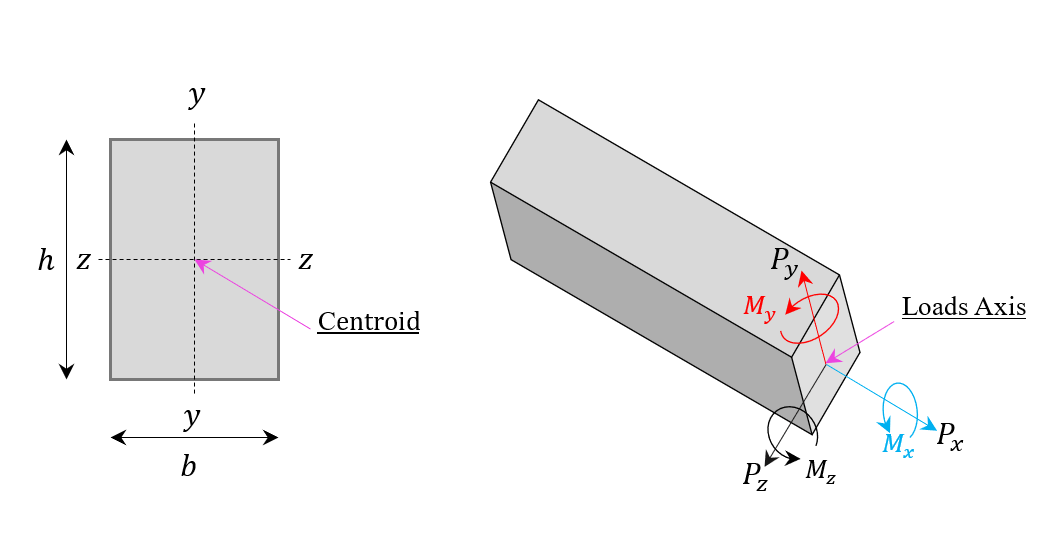

In [2]:
# b=5 and h=10 So considering above location of centroid
# coordinate of corners of rectangle becomes [-2.5,5] and [2.5,5]

Model(P=0, Mz=5000, crdsIz=-2.5, crdsIy=-5, crdsJz=2.5, crdsJy=5, numSubdivY=20, numSubdivZ=20)

Support Reaction (Px,Mz,My)=(-0.0 -5000.0 -0.0)

-------------------------------------------------------------------------------------------------------------------
Ybar= -0.0

By moving force to the center of the section the Mz= 5000.0
By moving force to the center of the section the My= -0.0

max and min of Calculated Stress at a fiber location= 57.14285714285725 -57.14285714285725
max and min of Handy Calculated Stress at a fiber location= 57.0000000000001 -57.0000000000001

max and min of Calculated Strain at a fiber location= 2.721088435374155e-05 -2.721088435374155e-05
max and min of Handy Calculated Strain at a fiber location= 2.7142857142857192e-05 -2.7142857142857192e-05
-------------------------------------------------------------------------------------------------------------------


### Axis at Centroid and  section is under Axial force(Px) and Mz

In [3]:
# b=5 and h=10 So considering above location of centroid
# coordinate of corners of rectangle becomes [-2.5,5] and [2.5,5]
Model(P=10000, Mz=5000, crdsIz=-2.5, crdsIy=-5, crdsJz=2.5, crdsJy=5, numSubdivY=20, numSubdivZ=20)

Support Reaction (Px,Mz,My)=(-10000.0 -5000.0 0.0)

-------------------------------------------------------------------------------------------------------------------
Ybar= -0.0

By moving force to the center of the section the Mz= 5000.0
By moving force to the center of the section the My= -0.0

max and min of Calculated Stress at a fiber location= 257.14285714285717 142.85714285714278
max and min of Handy Calculated Stress at a fiber location= 257.0000000000001 142.99999999999986

max and min of Calculated Strain at a fiber location= 0.00012244897959183676 6.80272108843537e-05
max and min of Handy Calculated Strain at a fiber location= 0.00012238095238095243 6.809523809523804e-05
-------------------------------------------------------------------------------------------------------------------


## Change Location of the Loads Axis

Considering Loads Axis at bottom of the section Centroid

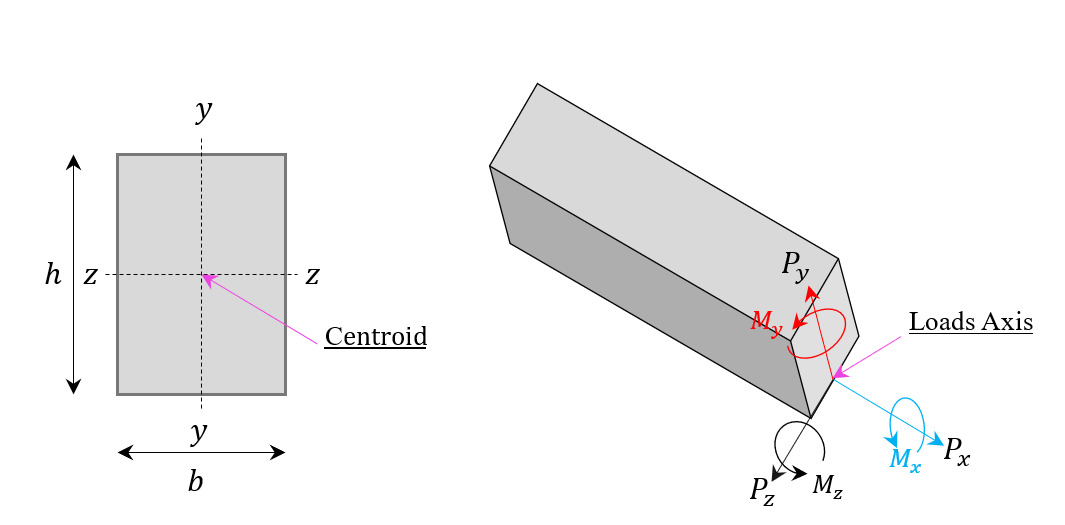

In [4]:
# b=5 and h=10 So considering above location of centroid
# coordinate of corners of rectangle becomes [-2.5,0] and [2.5,10]
Model(P=10000, Mz=5000, crdsIz=-2.5, crdsIy=0, crdsJz=2.5, crdsJy=10, numSubdivY=20, numSubdivZ=20)

Support Reaction (Px,Mz,My)=(-10000.0 -5000.0 0.0)

-------------------------------------------------------------------------------------------------------------------
Ybar= 5.0

By moving force to the center of the section the Mz= 55000.0
By moving force to the center of the section the My= -0.0

max and min of Calculated Stress at a fiber location= 828.5714285714283 -428.57142857142895
max and min of Handy Calculated Stress at a fiber location= 827.0000000000005 -427.0

max and min of Calculated Strain at a fiber location= 0.0003945578231292516 -0.0002040816326530614
max and min of Handy Calculated Strain at a fiber location= 0.00039380952380952403 -0.00020333333333333336
-------------------------------------------------------------------------------------------------------------------


## Change Location of the Loads Axis

Considering Loads Axis at corner of the section

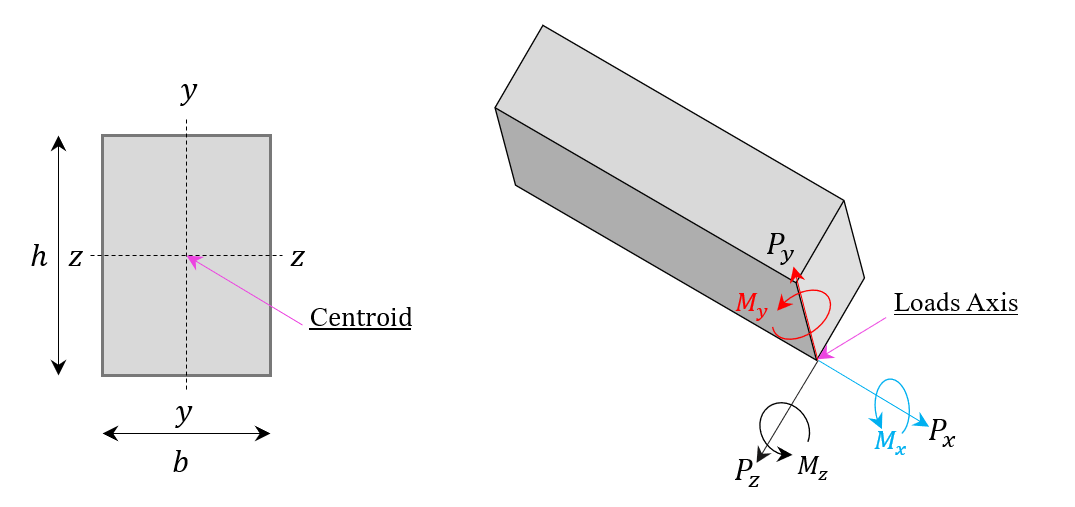

In [5]:
# b=5 and h=10 So considering above location of centroid
# coordinate of corners of rectangle becomes [0,0] and [5,10]
Model(P=10000, Mz=5000, crdsIz=0, crdsIy=0, crdsJz=5, crdsJy=10, numSubdivY=20, numSubdivZ=20)

Support Reaction (Px,Mz,My)=(-10000.0 -5000.0 0.0)

-------------------------------------------------------------------------------------------------------------------
Ybar= 5.0

By moving force to the center of the section the Mz= 55000.0
By moving force to the center of the section the My= 25000.0

max and min of Calculated Stress at a fiber location= 1399.999999999999 -999.9999999999989
max and min of Handy Calculated Stress at a fiber location= 1397.0000000000061 -997.0

max and min of Calculated Strain at a fiber location= 0.0006666666666666662 -0.00047619047619047565
max and min of Handy Calculated Strain at a fiber location= 0.0006652380952380982 -0.0004747619047619048
-------------------------------------------------------------------------------------------------------------------


# Results

* If user uses '-noCentroid' and the end of defining fiber section ***section('Fiber', secTag, '-GJ', GJ,'-noCentroid')*** OpenSees consider the location of the centroin exactly on the location of the origin that user considered else it is considered at the centroid of the section.

* OpenSees consider the location of the element internal loads at the centroid of the section.

**Ref:**
[Plane Sections Do Remain Plane By Prof. Michael H. Scott](https://portwooddigital.com/2022/05/15/plane-sections-do-remain-plane/)

# Plastic Investigation
In this part uniaxial nonliear response will be check in the pure bending and the strsses and strains in the fibers will be checked by handy calculations. In this part we won't speak about centroid location so the '-noCentroid' option removed from section command. At the first step like previouse part a function that create the model will be provide:

In [6]:
def ModelP(Mz, Fy, crdsIz, crdsIy, crdsJz, crdsJy, numSubdivY, numSubdivZ):
    import openseespy.opensees as ops
    from sympy import symbols, solve
    import matplotlib.pyplot as plt
    %matplotlib notebook

    
    # Modelling Part
    ops.wipe()
    ops.model('basic','-ndm',3)
    L=100
    ops.node(1,0,0,0)
    ops.node(2,L,0,0)
    ops.fix(1,1,1,1,1,1,1)

    matTag=1
    E=2.1e6
    epsyP=Fy/E
    ops.uniaxialMaterial('ElasticPP', matTag, E, epsyP)

    transfTag=1
    ops.geomTransf('Linear', transfTag,*[0,0,1])

    secTag=1
    GJ=1
    ops.section('Fiber', secTag, '-GJ', GJ)


    crdsI=[crdsIy, crdsIz]
    crdsJ=[crdsJy, crdsJz]
    b=abs(crdsIz-crdsJz)
    h=abs(crdsIy-crdsJy)
    I=b*h**3/12
    ops.patch('rect', matTag, numSubdivY, numSubdivZ, *crdsI, *crdsJ)


    integrationTag=1
    N=3
    ops.beamIntegration('Radau', integrationTag, secTag, N)


    eleTag=1
    eleNodes=[1,2]
    ops.element('forceBeamColumn', eleTag, *eleNodes, transfTag, integrationTag)

    tstag=1
    ops.timeSeries('Linear', tstag)
    patternTag=1
    ops.pattern('Plain', patternTag, tstag)
    nodeTag=2

    ops.load(nodeTag, *[0,0,0,0,0,Mz])


    # create the analysis
    ops.wipeAnalysis()                     # clear previously-define analysis parameters
    ops.constraints('Plain')               # how it handles boundary conditions
    ops.numberer('Plain')                  # renumber dof's to minimize band-width (optimization), if you want to
    ops.system('BandGeneral')              # how to store and solve the system of equations in the analysis
    ops.algorithm('Linear')                # use Linear algorithm for linear analysis
    ops.integrator("LoadControl", 0.01)     # create integrator
    ops.analysis("Static")                 # create analysis object

    # perform the analysis
    ops.analyze(100)
    
    
    # Support reaction
    ops.reactions()
    print(f'Support Reaction (Px,Mz,My)=({round(ops.nodeReaction(1,1),2)}', 
                                         f'{round(ops.nodeReaction(1,6),2)}',
                                         f'{round(ops.nodeReaction(1,5),2)})\n')

    # Expot Fiber Data
    #                      eleTag             secNum
    data = ops.eleResponse(eleTag,'section',3,'fiberData')
    # print('\nAll Fiber Data=',data, '\n')

    Ndata = len(data) 
    Nfibers = int(Ndata/5)
    #print('Nfibers=',Nfibers, '\n')

    y = data[0:Ndata:5] # Fibers y Coordinate
    z = data[1:Ndata:5] # Fibers z Coordinate
    # print('y=',y,'z=',z)

    A = data[2:Ndata:5]   # If you want fiber areas (Fibers Area)
    sig = data[3:Ndata:5] # Fibers Stress
    eps = data[4:Ndata:5] # Fibers Strain
    # print('A=',A)
    # print('sig=',sig)
    # print('eps=',eps)
    
    
    Ybar=round(sum([yi*ai for yi,ai in zip(y,A)])/sum([ai for ai in A]),2)
    # print('Ybar=',Ybar)
    AT=sum(A)
    zbar=sum([zi*ai for zi,ai in zip(z,A)])/sum([ai for ai in A])

    Iz=I
    
    # Handy Calculations
    ME=Fy*Iz/(h/2)  # Elastic moment
    # print('Elastic moment of the section is ', ME)
    
    MP=Fy*b*h/2*h/2 # Plastic moment
    # print('Plastic moment of the section is ', MP)
    
    
    if  ME>=Mz:
        print('Section is in the elastic range')
    elif Mz>MP:
        print('The input moment is greater than section plastic capacity and probably we encounter with opensees error before this message!')
    else:
        d = symbols('d') #elastic hight 
        Id= b*d**3/12
        expr= Fy*Id/(d/2)+Fy*(h/2-d/2)*b*(h/2+d/2)-Mz # Section moment equation
        d = max(solve(expr)) # Solve to find d
            

        # Handy calculations for Fibers Stress and Strain
        Y=[]
        EPS=[]
        SIG=[]
        HEPS=[]
        HSIG=[]
        for i,yi in enumerate(y):
            
            if round(yi,2) not in Y:
                Y.append(round(yi,2))
                
                HEPS.append(-epsyP/d*2*yi)                      # strain in ith fiber
                HSIG.append(-Fy/d*2*yi if abs(yi)<=d/2 else -Fy if yi>0 else Fy ) # Sterss in ith fiber
                
                EPS.append(eps[y.index(yi)])
                SIG.append(sig[y.index(yi)])

        
    # Plot Results
    plt.subplot(1, 2, 1)
    Z=[0]*len(Y)
    plt.plot(HSIG,Y)
    plt.plot(Z,Y,'black',alpha=0.4)
    plt.title('Hight-Stress')
    plt.xlabel('Stress')
    plt.ylabel('Y')
    plt.subplot(1, 2, 2)
    plt.plot(HEPS,Y)
    plt.title('Hight-Strain')
    plt.xlabel('Strain')
    plt.plot(Z,Y,'black',alpha=0.4)
    
    # Print Results
    print('-------------------------------------------------------------------------------------------------------------------')

    print(f'Elastic region height is equal {d}')
    
    print('Elastic moment of the section is ', ME)
    print('Plastic moment of the section is ', MP)
    
    # Results for each fiber:
    print('\nResults for each fiber is as following:\n')
    print('\t--yi------strain-----HandyStrain-----Stress-----HandyStress')
    for y, eps, heps, sig, hsig in zip(Y,EPS,HEPS,SIG,HSIG):
            print(f'\t{y}-----{round(eps,4)}-----{round(heps,4)}----------{round(sig,4)}--------{round(hsig,4)}')


Support Reaction (Px,Mz,My)=(0.0 -270000.58 -0.0)



<IPython.core.display.Javascript object>


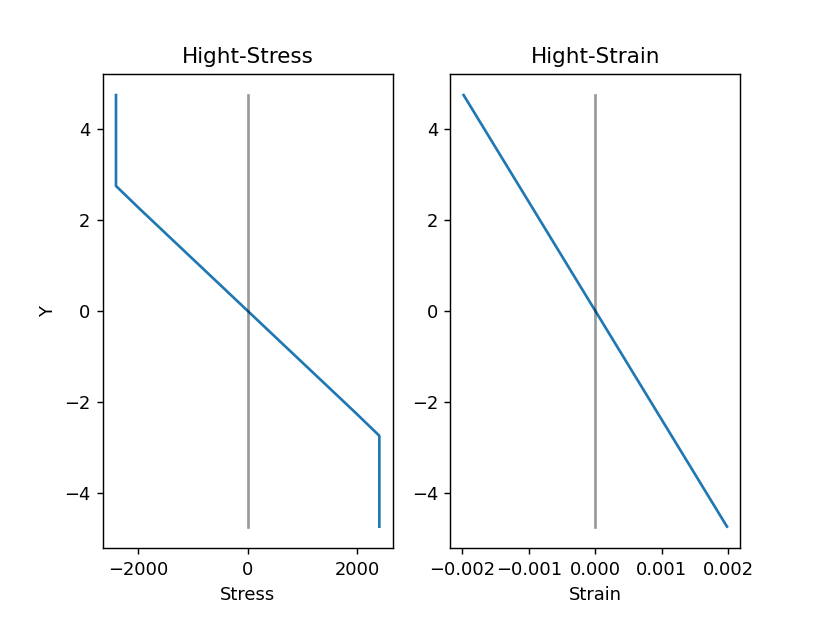

-------------------------------------------------------------------------------------------------------------------
Elastic region height is equal 5.47713428719801
Elastic moment of the section is  200000.0
Plastic moment of the section is  300000.0

Results for each fiber is as following:

	--yi------strain-----HandyStrain-----Stress-----HandyStress
	-4.75-----0.002-----0.0020----------2400.0--------2400
	-4.25-----0.0018-----0.0018----------2400.0--------2400
	-3.75-----0.0016-----0.0016----------2400.0--------2400
	-3.25-----0.0014-----0.0014----------2400.0--------2400
	-2.75-----0.0011-----0.0011----------2400.0--------2400
	-2.25-----0.0009-----0.0009----------1963.6615--------1971.8341
	-1.75-----0.0007-----0.0007----------1527.2923--------1533.6487
	-1.25-----0.0005-----0.0005----------1090.9231--------1095.4634
	-0.75-----0.0003-----0.0003----------654.5538--------657.2780
	-0.25-----0.0001-----0.0001----------218.1846--------219.0927
	0.25------0.0001------0.0001-----------21

In [9]:
ModelP(270001, 2400, -2.5, -5, 2.5, 5, 20, 20)

# Below Parts Have Not been Completed YET
*************************************************************************************************************************

# Investigation on torsion

In [8]:
import openseespy.opensees as ops
import matplotlib.pyplot as plt
%matplotlib notebook
ops.wipe()
ops.model('basic','-ndm',3)
L=100
ops.node(1,0,0,0)
ops.node(2,L,0,0)
ops.fix(1,1,1,1,1,1,1)

matTag=1
E=2.1e6
epsyP=1
ops.uniaxialMaterial('ElasticPP', matTag, E, epsyP)


transfTag=1
ops.geomTransf('Linear', transfTag,*[0,0,1])
r=10
J=3.1415*r**4/4
secTag=1
G=E/2/(1+0.3)
GJ=G*J
ops.section('Fiber', secTag, '-GJ', GJ)

numSubdivCirc=20
numSubdivRad=20

center=[0,0]
rad=[0,r]
ang=[0,360]
crdsI=[0,0]
crdsJ=[h,b]
ops.patch('circ', matTag, numSubdivCirc, numSubdivRad, *center, *rad, *ang)


integrationTag=1
N=3
ops.beamIntegration('Radau', integrationTag, secTag, N)


eleTag=1
eleNodes=[1,2]
ops.element('forceBeamColumn', eleTag, *eleNodes, transfTag, integrationTag)

tstag=1
ops.timeSeries('Linear', tstag)
patternTag=1
ops.pattern('Plain', patternTag, tstag)
nodeTag=2
T=5000000
ops.load(nodeTag, *[0,0,0,T,0,0])


# create the analysis
ops.wipeAnalysis()    # clear previously-define analysis parameters
ops.constraints('Plain')    # how it handles boundary conditions
ops.numberer('Plain')    # renumber dof's to minimize band-width (optimization), if you want to
ops.system('BandGeneral') # how to store and solve the system of equations in the analysis
ops.algorithm('Linear') # use Linear algorithm for linear analysis
# create integrator
ops.integrator("LoadControl", 0.1)
# create analysis object
ops.analysis("Static")

# perform the analysis
ops.analyze(10)
ops.reactions()
print('OpenSees Support Reaction=',ops.nodeReaction(1))
print('OpenSees maximum Disp=',ops.nodeDisp(2))
# print('Handy Calculated Maximum Delta=',M*L**2/2/E/I)
# print('Handy Calculated Maximum Theta=',M*L/E/I)
print('-------------------------------------------------------------------------------------------------------------------')
#                    eleTag             secNum
data = ops.eleResponse(eleTag,'section',3,'fiberData')
# print('\nAll Fiber Data=',data, '\n')
Ndata = len(data)
Nfibers = int(Ndata/5)
# print('Nfibers=',Nfibers, '\n')
print('data[1:5]=',data[0:6])
y = data[0:Ndata:5]
z = data[1:Ndata:5]
# print('y=',y,'\nz=',z)

A = data[2:Ndata:5] # If you want fiber areas
sig = data[3:Ndata:5]
eps = data[4:Ndata:5]
# print('A=',A)
# print('sig=',sig)
# print('eps=',eps)

print('J=',Ybar)
print('max and min of handy Calculated Stress at a fiber location=', T/G/J*L)
print('max and min of Calculated Stress at a fiber location=', max(sig), min(sig))
print('')
print('max and min of Calculated Strain at a fiber location=', max(eps), min(eps))
print('-------------------------------------------------------------------------------------------------------------------')

plt.scatter(y,z)



NameError: name 'h' is not defined